# Lunar Lander DQN - Analyse des Performances

Ce notebook analyse les résultats d'entraînement de l'agent Deep Q-Learning.

## Métriques clés:
1. **Taux de succès** = Épisodes réussis / Total épisodes
2. **Temps d'entraînement** = Durée totale en secondes
3. **Courbe d'apprentissage** = Évolution des récompenses

## 1. Chargement des données

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Style des graphiques
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Charger les statistiques
stats_path = Path('statistics/training_stats.json')

if not stats_path.exists():
    raise FileNotFoundError("Fichier non trouvé. Exécutez: python train.py")

with open(stats_path, 'r') as f:
    stats = json.load(f)

# Conversion en arrays
rewards = np.array(stats['episode_rewards'])
successes = np.array(stats['episode_successes'])
epsilons = np.array(stats['epsilons'])
losses = np.array(stats['losses'])
episodes = np.arange(1, len(rewards) + 1)

print(f"Données chargées: {len(rewards)} épisodes")

Données chargées: 1500 épisodes


## 2. Métriques Principales

Les deux métriques demandées:
- **(i) Taux de succès** = nombre d'atterrissages réussis / nombre total d'épisodes
- **(ii) Temps d'entraînement** = durée totale

In [2]:
# Calcul des métriques
total_episodes = len(rewards)
total_successes = int(successes.sum())
success_rate = total_successes / total_episodes
training_time = stats['training_time']

# Affichage
print("=" * 55)
print("          MÉTRIQUES DE PERFORMANCE")
print("=" * 55)
print()
print(f"(i) TAUX DE SUCCÈS")
print(f"    {total_successes} / {total_episodes} = {100*success_rate:.2f}%")
print()
print(f"(ii) TEMPS D'ENTRAÎNEMENT")
print(f"     {training_time:.1f} secondes ({training_time/60:.1f} minutes)")
print()
print(f"Statistiques supplémentaires:")
print(f"  - Récompense moyenne: {rewards.mean():.1f}")
print(f"  - Récompense max: {rewards.max():.1f}")
print(f"  - Steps totaux: {stats['total_steps']:,}")

          MÉTRIQUES DE PERFORMANCE

(i) TAUX DE SUCCÈS
    1126 / 1500 = 75.07%

(ii) TEMPS D'ENTRAÎNEMENT
     921.3 secondes (15.4 minutes)

Statistiques supplémentaires:
  - Récompense moyenne: 81.7
  - Récompense max: 188.8
  - Steps totaux: 896,000


## 3. Courbe d'Apprentissage: Récompenses

Cette courbe montre l'évolution des récompenses au cours de l'entraînement.

**Interprétation:**
- Tendance à la hausse = l'agent apprend
- Variance qui diminue = comportement plus stable
- Plateau = convergence

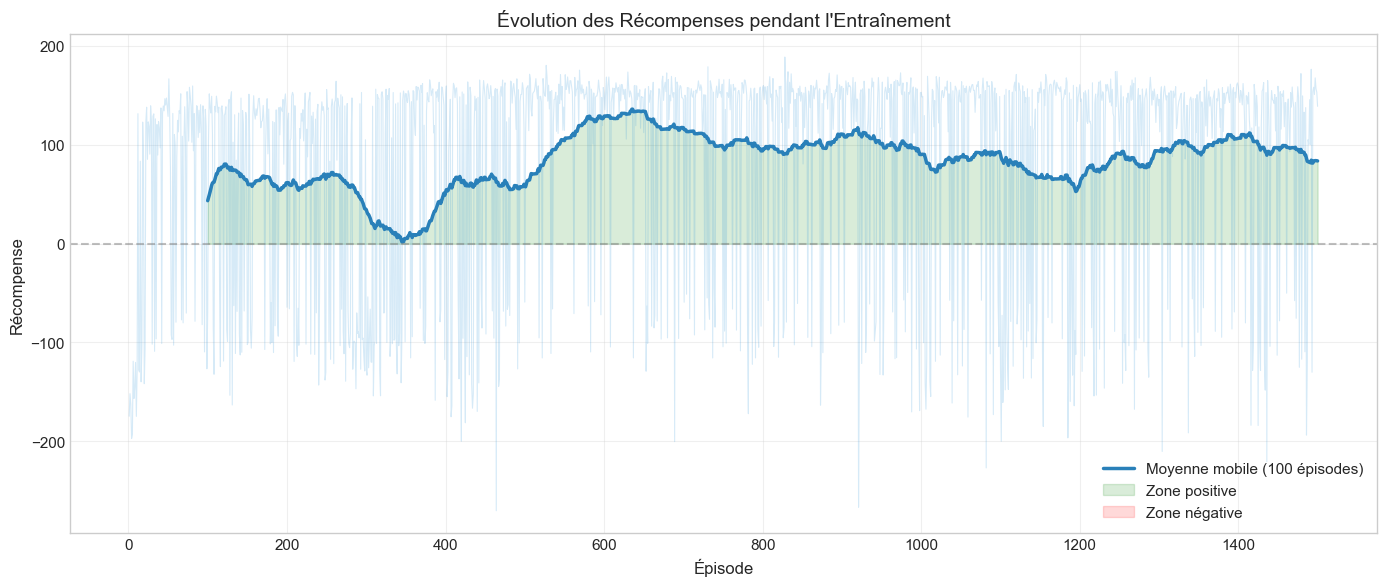

In [3]:
def moving_average(data, window=100):
    """Calcule la moyenne mobile."""
    cumsum = np.cumsum(np.insert(data, 0, 0))
    return (cumsum[window:] - cumsum[:-window]) / window

fig, ax = plt.subplots(figsize=(14, 6))

# Récompenses brutes
ax.plot(episodes, rewards, alpha=0.2, color='#3498db', linewidth=0.8)

# Moyenne mobile (100 épisodes)
window = 100
if len(rewards) >= window:
    ma = moving_average(rewards, window)
    ma_episodes = episodes[window-1:]
    ax.plot(ma_episodes, ma, color='#2980b9', linewidth=2.5, 
            label=f'Moyenne mobile ({window} épisodes)')

# Ligne zéro
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# Zones colorées
if len(rewards) >= window:
    ax.fill_between(ma_episodes, 0, ma, where=(ma > 0), 
                    alpha=0.15, color='green', label='Zone positive')
    ax.fill_between(ma_episodes, 0, ma, where=(ma < 0), 
                    alpha=0.15, color='red', label='Zone négative')

ax.set_xlabel('Épisode')
ax.set_ylabel('Récompense')
ax.set_title('Évolution des Récompenses pendant l\'Entraînement')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('statistics/rewards_curve.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Courbe du Taux de Succès

Cette courbe montre l'évolution du pourcentage d'atterrissages réussis.

**Objectifs:**
- 50% = agent fonctionnel
- 75% = bon agent
- 90%+ = excellent agent

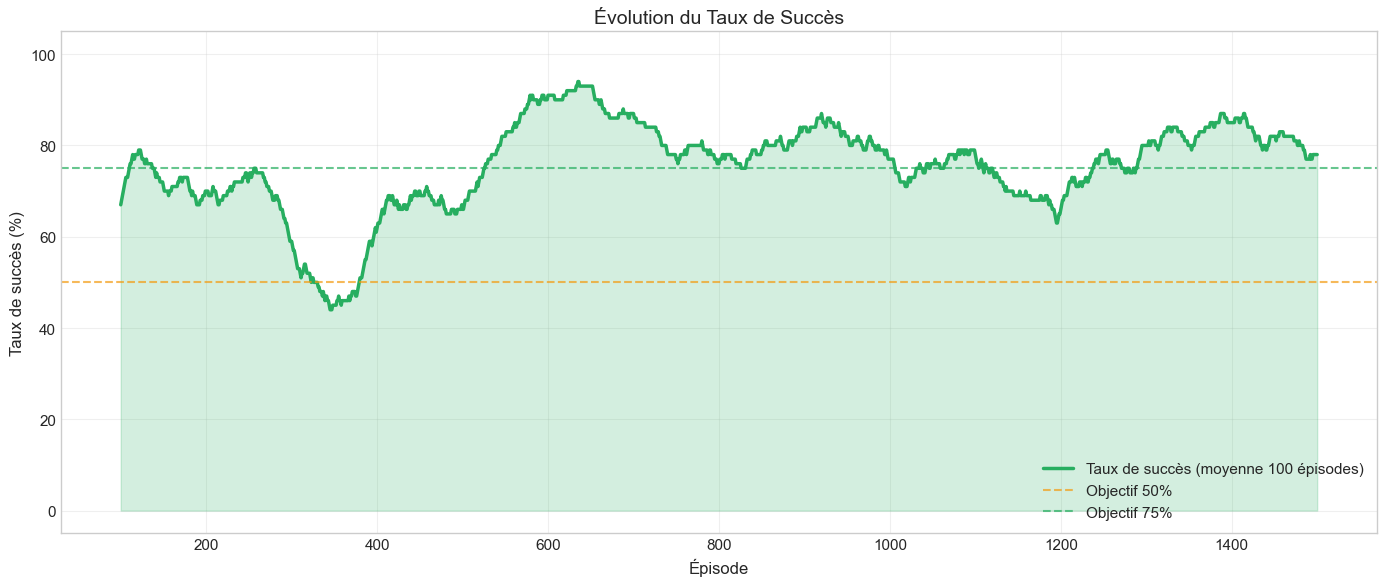

In [4]:
fig, ax = plt.subplots(figsize=(14, 6))

# Taux de succès mobile
window = 100
if len(successes) >= window:
    success_ma = moving_average(successes.astype(float), window) * 100
    ma_episodes = episodes[window-1:]
    ax.plot(ma_episodes, success_ma, color='#27ae60', linewidth=2.5,
            label=f'Taux de succès (moyenne {window} épisodes)')
    ax.fill_between(ma_episodes, 0, success_ma, alpha=0.2, color='#27ae60')

# Lignes de référence
ax.axhline(y=50, color='#f39c12', linestyle='--', alpha=0.7, label='Objectif 50%')
ax.axhline(y=75, color='#27ae60', linestyle='--', alpha=0.7, label='Objectif 75%')

ax.set_xlabel('Épisode')
ax.set_ylabel('Taux de succès (%)')
ax.set_title('Évolution du Taux de Succès')
ax.set_ylim(-5, 105)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('statistics/success_rate_curve.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Stratégie d'Exploration (Epsilon)

Epsilon contrôle le compromis exploration/exploitation:
- **ε = 1.0**: 100% exploration (actions aléatoires)
- **ε = 0.01**: 1% exploration (actions optimales)

La décroissance exponentielle permet d'explorer au début puis d'exploiter ensuite.

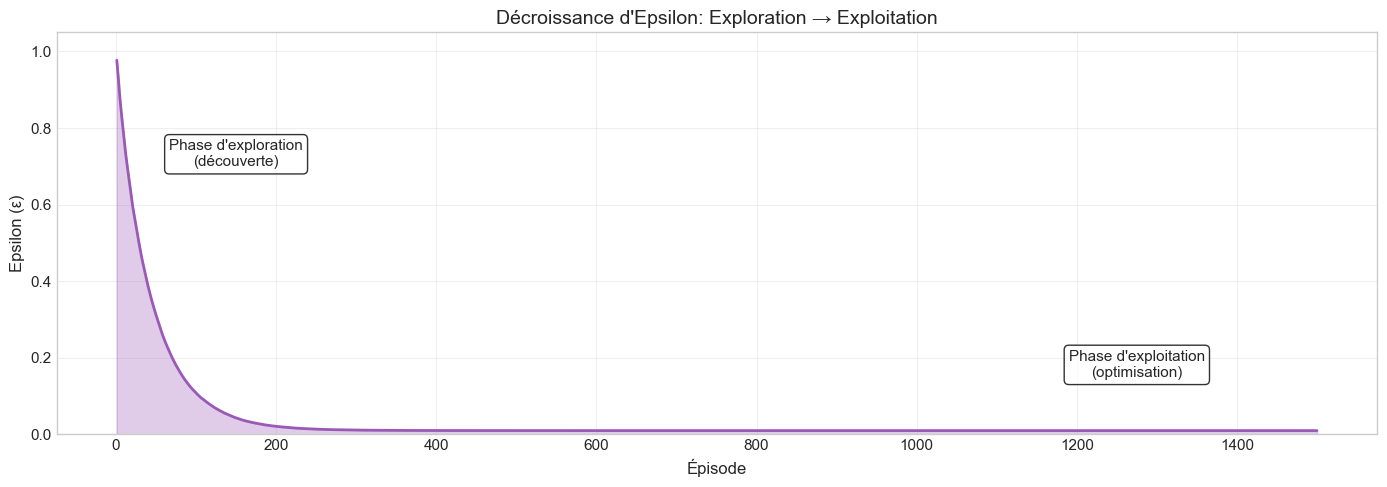

In [5]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(episodes, epsilons, color='#9b59b6', linewidth=2)
ax.fill_between(episodes, 0, epsilons, alpha=0.3, color='#9b59b6')

# Annotations
ax.annotate('Phase d\'exploration\n(découverte)', 
            xy=(len(episodes)*0.1, 0.7), fontsize=11, ha='center',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax.annotate('Phase d\'exploitation\n(optimisation)', 
            xy=(len(episodes)*0.85, 0.15), fontsize=11, ha='center',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.set_xlabel('Épisode')
ax.set_ylabel('Epsilon (ε)')
ax.set_title('Décroissance d\'Epsilon: Exploration → Exploitation')
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('statistics/epsilon_curve.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Fonction de Perte (Loss)

La loss mesure l'erreur entre les Q-valeurs prédites et les cibles.

**Interprétation:**
- Diminution = apprentissage en cours
- Stabilisation = convergence
- Augmentation = problème (learning rate trop élevé?)

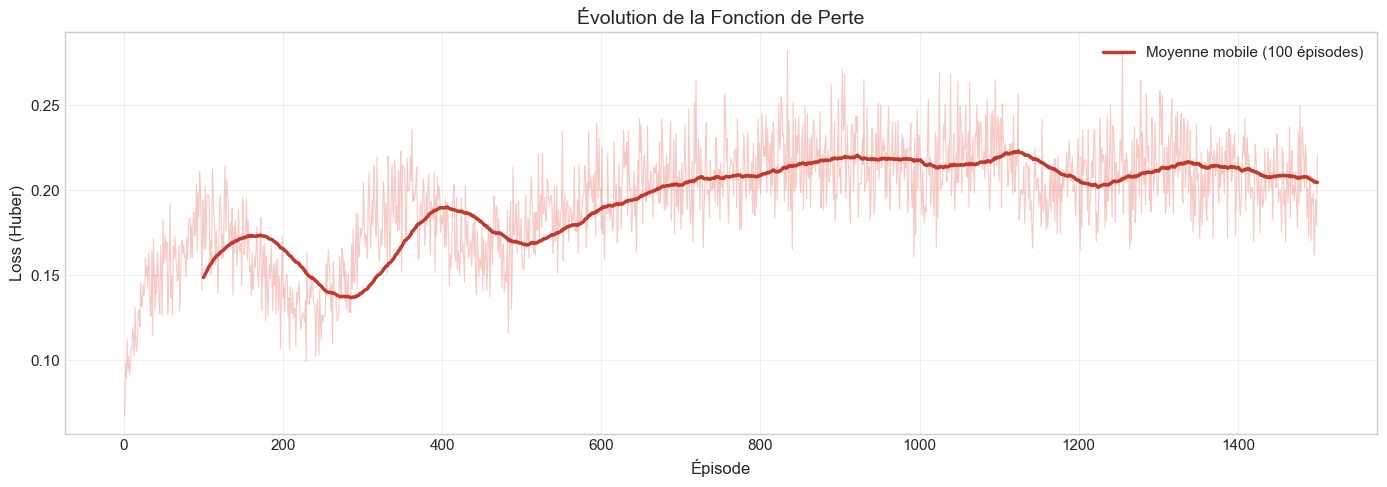

In [6]:
# Filtrer les valeurs nulles
valid_mask = losses > 0
valid_losses = losses[valid_mask]
valid_episodes = episodes[valid_mask]

if len(valid_losses) > 0:
    fig, ax = plt.subplots(figsize=(14, 5))
    
    ax.plot(valid_episodes, valid_losses, alpha=0.3, color='#e74c3c', linewidth=0.8)
    
    # Moyenne mobile
    window = min(100, len(valid_losses))
    if len(valid_losses) >= window:
        loss_ma = moving_average(valid_losses, window)
        ma_episodes = valid_episodes[window-1:]
        ax.plot(ma_episodes, loss_ma, color='#c0392b', linewidth=2.5,
                label=f'Moyenne mobile ({window} épisodes)')
    
    ax.set_xlabel('Épisode')
    ax.set_ylabel('Loss (Huber)')
    ax.set_title('Évolution de la Fonction de Perte')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('statistics/loss_curve.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Pas de données de loss disponibles.")

## 7. Dashboard Complet

Vue d'ensemble de toutes les métriques sur un seul graphique.

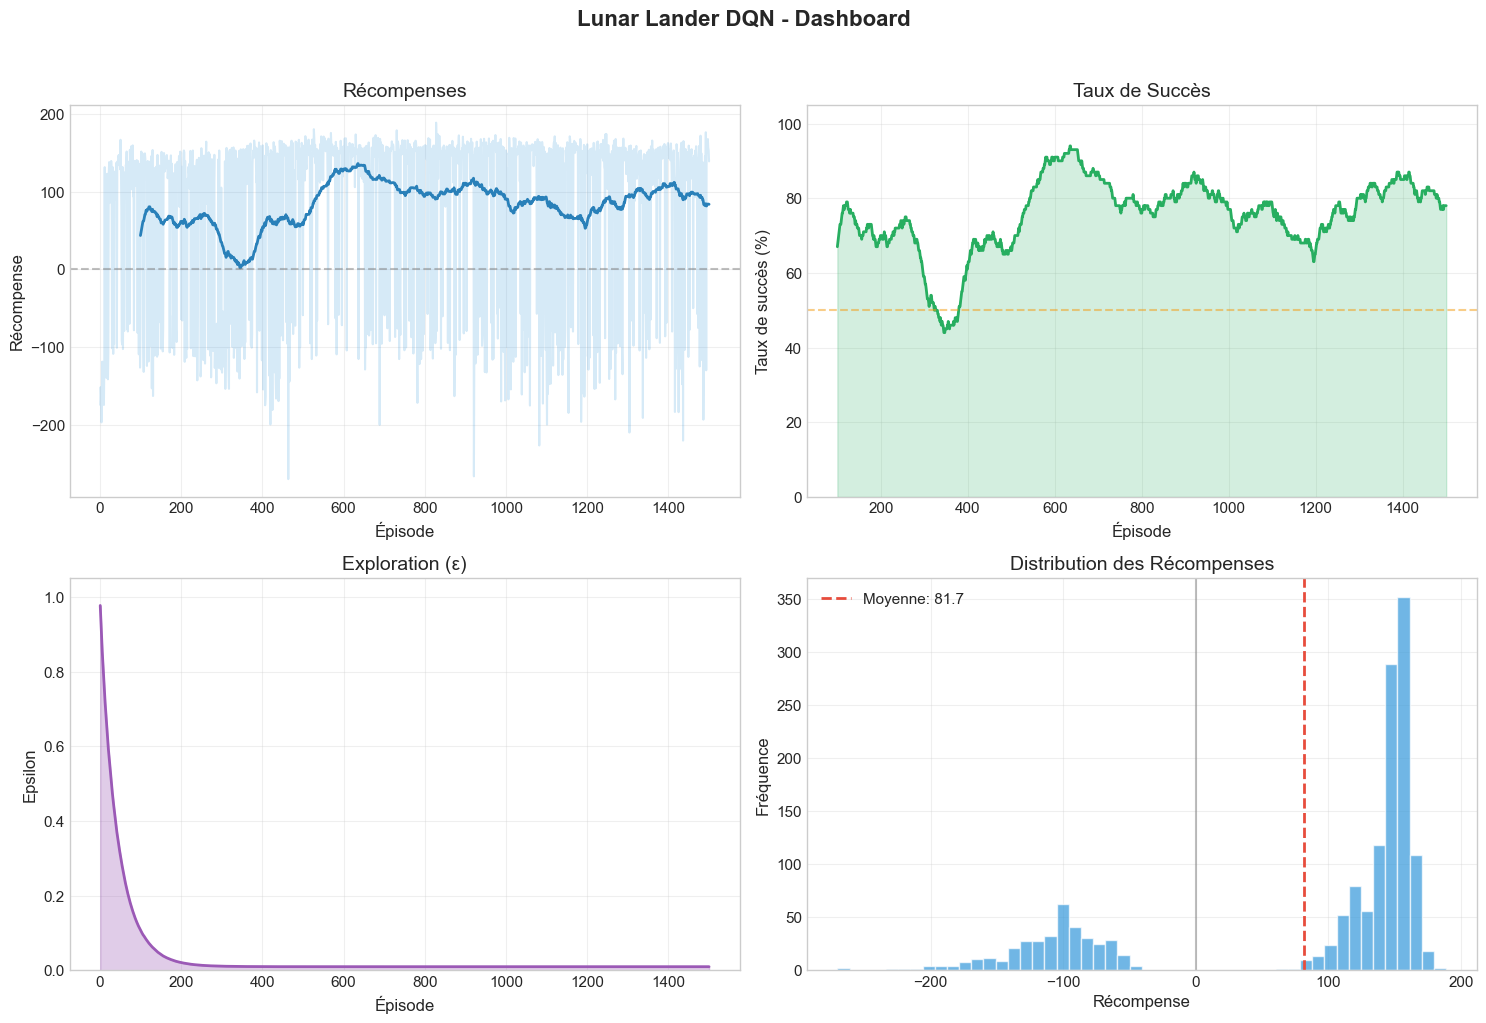

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
window = 100

# 1. Récompenses
ax1 = axes[0, 0]
ax1.plot(episodes, rewards, alpha=0.2, color='#3498db')
if len(rewards) >= window:
    ma = moving_average(rewards, window)
    ax1.plot(episodes[window-1:], ma, color='#2980b9', linewidth=2)
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('Épisode')
ax1.set_ylabel('Récompense')
ax1.set_title('Récompenses')
ax1.grid(True, alpha=0.3)

# 2. Taux de succès
ax2 = axes[0, 1]
if len(successes) >= window:
    success_ma = moving_average(successes.astype(float), window) * 100
    ax2.plot(episodes[window-1:], success_ma, color='#27ae60', linewidth=2)
    ax2.fill_between(episodes[window-1:], 0, success_ma, alpha=0.2, color='#27ae60')
ax2.axhline(y=50, color='#f39c12', linestyle='--', alpha=0.5)
ax2.set_xlabel('Épisode')
ax2.set_ylabel('Taux de succès (%)')
ax2.set_title('Taux de Succès')
ax2.set_ylim(0, 105)
ax2.grid(True, alpha=0.3)

# 3. Epsilon
ax3 = axes[1, 0]
ax3.plot(episodes, epsilons, color='#9b59b6', linewidth=2)
ax3.fill_between(episodes, 0, epsilons, alpha=0.3, color='#9b59b6')
ax3.set_xlabel('Épisode')
ax3.set_ylabel('Epsilon')
ax3.set_title('Exploration (ε)')
ax3.set_ylim(0, 1.05)
ax3.grid(True, alpha=0.3)

# 4. Distribution des récompenses
ax4 = axes[1, 1]
ax4.hist(rewards, bins=50, color='#3498db', alpha=0.7, edgecolor='white')
ax4.axvline(x=rewards.mean(), color='#e74c3c', linestyle='--', linewidth=2,
            label=f'Moyenne: {rewards.mean():.1f}')
ax4.axvline(x=0, color='gray', linestyle='-', alpha=0.5)
ax4.set_xlabel('Récompense')
ax4.set_ylabel('Fréquence')
ax4.set_title('Distribution des Récompenses')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('Lunar Lander DQN - Dashboard', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('statistics/dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Analyse par Phases

Comparaison des performances entre le début, le milieu et la fin de l'entraînement.

In [8]:
# Diviser en 4 phases
n_phases = 4
phase_size = len(rewards) // n_phases

print("=" * 70)
print("                      ANALYSE PAR PHASES")
print("=" * 70)
print(f"{'Phase':<12} {'Épisodes':<15} {'Récomp. moy.':<14} {'Taux succès':<14} {'Epsilon'}")
print("-" * 70)

for i in range(n_phases):
    start = i * phase_size
    end = (i + 1) * phase_size if i < n_phases - 1 else len(rewards)
    
    phase_rewards = rewards[start:end]
    phase_successes = successes[start:end]
    phase_epsilon = epsilons[end-1]
    
    phase_name = ["Début", "Début-Milieu", "Milieu-Fin", "Fin"][i]
    
    print(f"{phase_name:<12} {start+1:>4}-{end:<10} {phase_rewards.mean():>+10.1f}    "
          f"{100*phase_successes.mean():>10.1f}%    {phase_epsilon:.4f}")

print("=" * 70)

                      ANALYSE PAR PHASES
Phase        Épisodes        Récomp. moy.   Taux succès    Epsilon
----------------------------------------------------------------------
Début           1-375             +43.8          63.2%    0.0103
Début-Milieu  376-750            +101.4          80.8%    0.0100
Milieu-Fin    751-1125            +91.1          77.3%    0.0100
Fin          1126-1500            +90.4          78.9%    0.0100


## 9. Analyse et Conclusions

In [9]:
# Comparaison début vs fin
n_compare = min(100, len(rewards) // 4)

initial_reward = rewards[:n_compare].mean()
final_reward = rewards[-n_compare:].mean()
reward_improvement = final_reward - initial_reward

initial_success = successes[:n_compare].mean() * 100
final_success = successes[-n_compare:].mean() * 100

print("\n" + "=" * 55)
print("              ANALYSE DES RÉSULTATS")
print("=" * 55)

print("\n PROGRESSION DE L'APPRENTISSAGE:")
print(f"   Récompense début ({n_compare} premiers): {initial_reward:+.1f}")
print(f"   Récompense fin ({n_compare} derniers):   {final_reward:+.1f}")
print(f"   Amélioration: {reward_improvement:+.1f}")

print("\n TAUX DE SUCCÈS:")
print(f"   Début: {initial_success:.1f}%")
print(f"   Fin:   {final_success:.1f}%")
print(f"   Amélioration: {final_success - initial_success:+.1f} points")

print("\n EFFICACITÉ:")
print(f"   Temps total: {training_time:.0f}s ({training_time/60:.1f} min)")
print(f"   Vitesse: {stats['total_steps']/training_time:.0f} steps/s")

# Verdict
print("\n" + "=" * 55)
if final_success >= 70:
    print(" VERDICT: EXCELLENT - L'agent maîtrise l'atterrissage!")
elif final_success >= 50:
    print(" VERDICT: BON - L'agent réussit régulièrement")
elif final_success >= 25:
    print(" VERDICT: MOYEN - L'agent progresse mais peut s'améliorer")
elif reward_improvement > 50:
    print(" VERDICT: EN PROGRESSION - L'agent apprend, continuer l'entraînement")
else:
    print(" VERDICT: À AMÉLIORER - Ajuster les hyperparamètres")
print("=" * 55)


              ANALYSE DES RÉSULTATS

 PROGRESSION DE L'APPRENTISSAGE:
   Récompense début (100 premiers): +43.5
   Récompense fin (100 derniers):   +83.7
   Amélioration: +40.2

 TAUX DE SUCCÈS:
   Début: 67.0%
   Fin:   78.0%
   Amélioration: +11.0 points

 EFFICACITÉ:
   Temps total: 921s (15.4 min)
   Vitesse: 973 steps/s

 VERDICT: EXCELLENT - L'agent maîtrise l'atterrissage!


---

## Commandes utiles

```bash
# Entraîner l'agent
python train.py --episodes 1000

# Visualiser l'agent entraîné
python play.py --model models/base/final_model.pt

# Jouer manuellement
python play.py --manual
```